# Análisis Funcional
### *Sheila Santomé*
En este notebook se detalla la **pipeline** seguida para realizar el análisis funcional de la expreisón diferencial de las muestras, utilizando como ejemplo los datos de **Ratón 3**. El mismo flujo de trabajo puede aplicarse a las muestras de **Ratón 1** y a los dos **pools**, únicamente cambiando las rutas de los archivos de entrada y salida, las cuales están indicadas en el código.

------ 


## Importar librerias

In [ ]:
import anndata
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scanpy as sc
import seaborn as sns


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargar objetos
En este bloque de código se carga el **objeto pickle** generado al final del notebook de preprocesado, después de haber calculado las métricas de QC.


In [ ]:
# Cambiar a la ruta del fichero que se quiera emplear
file_path = "./pickles/counts_mouse_3_barcode_qcmetrics.pkl"  

In [ ]:
with open(file_path, "rb") as f:
    
    counts = pickle.load(f)

# Normalización de los datos

A continuación, se realizará la **normalización de los conteos de genes** utilizando las funciones de **Scanpy**: **`normalize_total`** y **`log1p`**. La normalización por **`normalize_total`** ajusta los conteos de cada célula para que sean comparables entre células, mientras que **`log1p`** aplica una transformación logarítmica para estabilizar la varianza y reducir el efecto de valores extremadamente altos. Este paso es fundamental para poder realizar análisis posteriores como identificación de genes variables, reducción de dimensionalidad y clustering de manera más confiable.


In [ ]:
sc.pp.normalize_total(counts, target_sum=1e4) #normalize every cell to 10,000 UMI


c:\Python311\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
counts.X.sum(axis = 1)


matrix([[ 9999.999],
        [10000.   ],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.001],
        [ 9999.999]], shape=(16499, 1), dtype=float32)

In [ ]:
sc.pp.log1p(counts)
counts.X.sum(axis = 1)


matrix([[3016.2988],
        [2992.737 ],
        [1494.9773],
        ...,
        [3206.0283],
        [2632.6162],
        [2668.5037]], shape=(16499, 1), dtype=float32)

### Guardar objeto

En el siguiente bloque se guardarán los conteos crudos y se guardará el objeto Anndata como un pickle, en caso de no querer guardarlo no será necesario ejecutar el bloque.

In [ ]:
counts.raw = counts

In [ ]:
file_path = "./pickles/counts_mouse_3_barcode_normalized.pkl" #Cambiar por el path en el que se quiera guardar el archivo

with open(file_path, 'wb') as f:
    pickle.dump(counts, f)

## Clustering   

En este apartado se realizará la **clusterización de los datos** utilizando las funciones del paquete **Scanpy**.  
El objetivo es identificar grupos de células con perfiles de expresión génica similares.

El proceso incluye los siguientes pasos:

* Eliminación de efectos no deseados

    - **`regress_out`**: elimina efectos no biológicos o variables de confusión mediante regresión lineal.  
    - **`scale`**: estandariza los valores de expresión para que cada gen tenga una media de 0 y una desviación estándar de 1, mejorando el rendimiento de los métodos posteriores.

* Reducción de la dimensionalidad

    - **`pca`** (*Principal Component Analysis*): calcula las componentes principales que capturan la mayor parte de la variabilidad de los datos.  
    - **`pca_variance_ratio`**: muestra el porcentaje de la varianza total explicada por cada componente principal, ayudando a determinar cuántas componentes conservar.
* Clusterización y visualización

    - **`tl.leiden`**: aplica el algoritmo **Leiden**, un método de detección de comunidades basado en grafos, para identificar **clusters** o grupos celulares.  
    - **`tl.umap`**: genera una representación bidimensional utilizando **UMAP (Uniform Manifold Approximation and Projection)**, lo que permite **visualizar los clusters** de manera clara y estructurada.


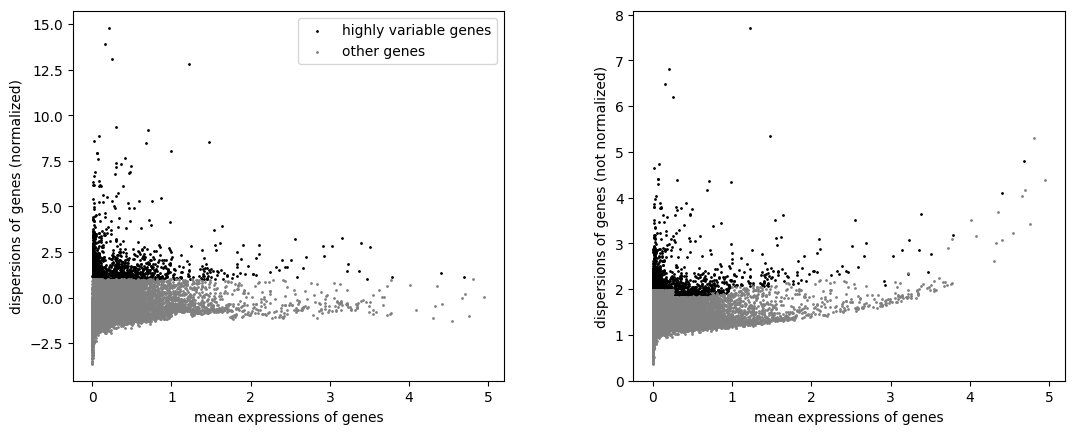

In [ ]:

sc.pp.highly_variable_genes(counts, n_top_genes = 2000)
sc.pl.highly_variable_genes(counts)


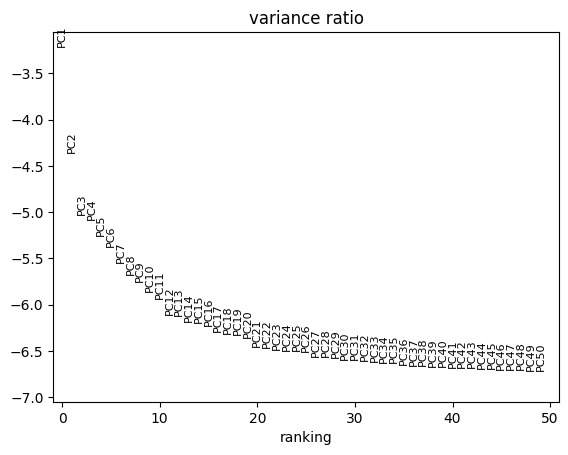

In [ ]:

sc.pp.regress_out(counts, ['total_counts','pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score'])
sc.pp.scale(counts, max_value=10)
sc.tl.pca(counts, svd_solver='arpack')
sc.pl.pca_variance_ratio(counts, log=True, n_pcs = 50)

### Selección del número de componentes principales

Al observar la gráfica generada con la función **`pl.pca_variance_ratio`**, se determina que el número óptimo de componentes principales para realizar el **clustering** del **ratón 3** es **PC13**, ya que en ese punto se observa el *“codo”* de la gráfica (el punto donde la ganancia en varianza explicada comienza a disminuir notablemente). Aunque podría considerarse incluir hasta **20 componentes**, donde aparece un segundo codo, el incremento en la varianza explicada no es significativo. Por lo tanto, utilizar más componentes solo aumentaría el **tiempo de ejecución del clustering** sin aportar una mejora sustancial en la calidad de la agrupación.

El número óptimo de componentes puede variar dependiendo de la muestra, en el código que se muestra a continuación se indica donde cambiar el valor. A mayores, también se inidcará donde cambiar el parámetro de *resolución* que indica que tan exacta es la división de los grupos, valores cercanos a 1 tenderána a crear más grupos u¡y valores cercanos a 0 tenderán a hacer menos clústeres. En este estudio, se empleará una resolución de 0,3 que fue lo que se consideró óptimo para los datos con los que se trabaja.

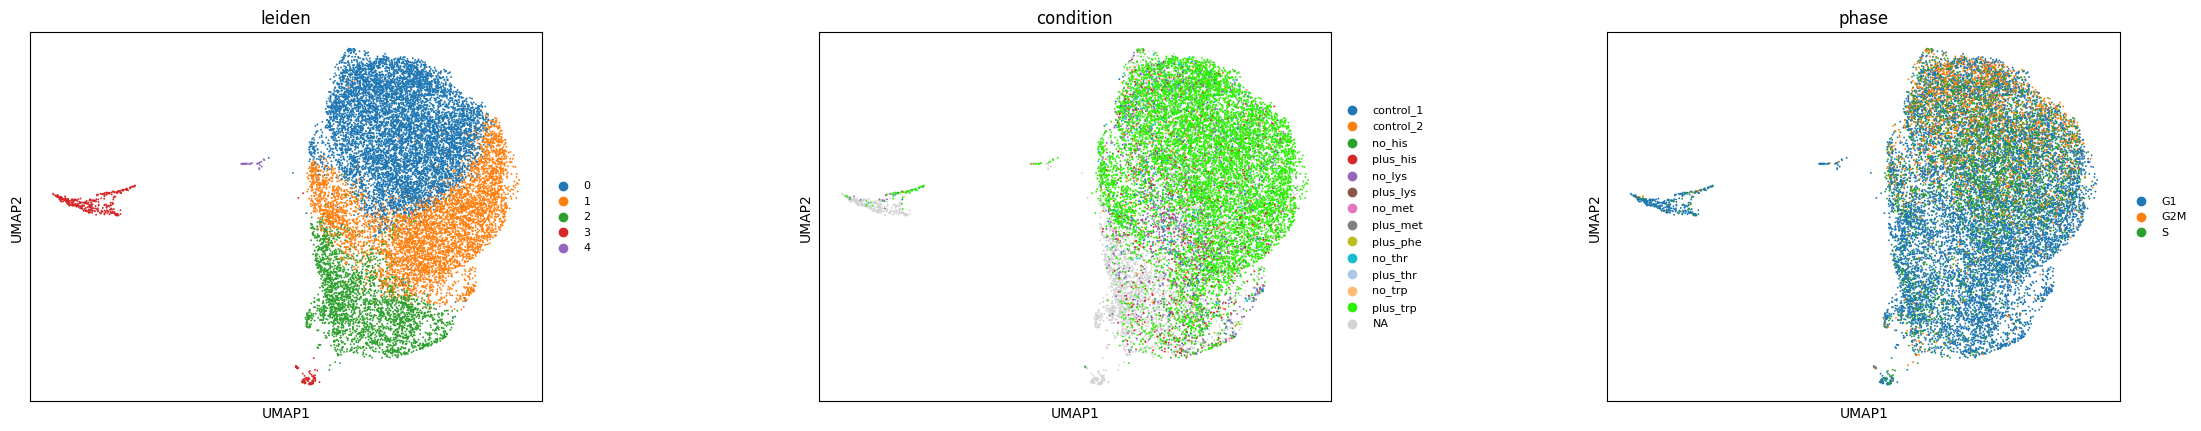

In [ ]:
# Guardar el PCA original
counts.obsm['X_pca_orig'] = counts.obsm['X_pca'].copy()


sc.pp.neighbors(
    counts,
    n_pcs=13, #Cambiar parámetro a las componentes óptimas para cada muestra
    n_neighbors=20,
    random_state=42
)

# Guardar grafo de vecinos original
counts.uns['neighbors_orig'] = counts.uns['neighbors'].copy()


sc.tl.leiden(
    counts,
    resolution=0.3, #Variar entre 0 y 1 dependiendo de la resolución que se busque
    random_state=42
)


sc.tl.umap(
    counts,
    min_dist=0.2,
    spread=1.0,
    random_state=42
)

# Paleta de colores para condición
palette = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#aec7e8", "#ffbb78",
    "#2df006", "#f81010c9"
]
counts.uns["condition_colors"] = palette


def plot_umap(adata, color_list):
    # Restaurar PCA y vecinos fijos
    adata.obsm['X_pca'] = adata.obsm['X_pca_orig']
    adata.uns['neighbors'] = adata.uns['neighbors_orig']
    
    # Plot
    sc.pl.umap(
        adata,
        color=color_list,
        legend_loc="right margin",
        legend_fontsize=8,
        wspace=0.4
    )

plot_umap(counts, ["leiden", "condition", "phase"])


### Graficas complementarias a clusteres

Además del **UMAP**, se incluyen **gráficas complementarias** que muestran los **porcentajes de genes mitocondriales**, **ribosomales** y el **conteo total de genes** por clúster.  Estas representaciones son útiles para **evaluar la calidad celular** dentro de cada clúster, ya que permiten identificar si existe algún grupo compuesto principalmente por células en **malas condiciones** (por ejemplo, con alta expresión mitocondrial o bajo número de genes detectados).  En caso de detectar un clúster con estas características, puede considerarse **su eliminación** antes de continuar con los análisis posteriores.

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_6768\395316124.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


<function matplotlib.pyplot.show(close=None, block=None)>

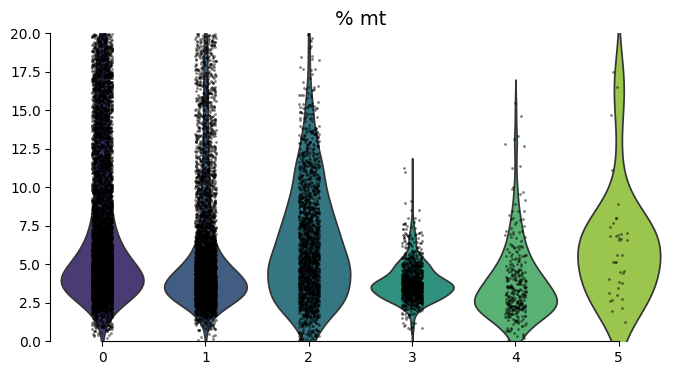

In [ ]:
df = counts.obs.copy()

plt.figure(figsize=(8,4))

# Violin plot
sns.violinplot(
    x='leiden',
    y='pct_counts_mt',
    data=df,
    palette='viridis',
    inner=None  
)


sns.stripplot(
    x='leiden',
    y='pct_counts_mt',
    data=df,
    color='k',      
    size=2,         # tamaño de los puntos
    alpha=0.5,      # transparencia
    jitter=True    
)

plt.ylim(0,20)
plt.title("% mt", fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.grid(False)
sns.despine(trim=True)
plt.show


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_6768\4037955618.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


<function matplotlib.pyplot.show(close=None, block=None)>

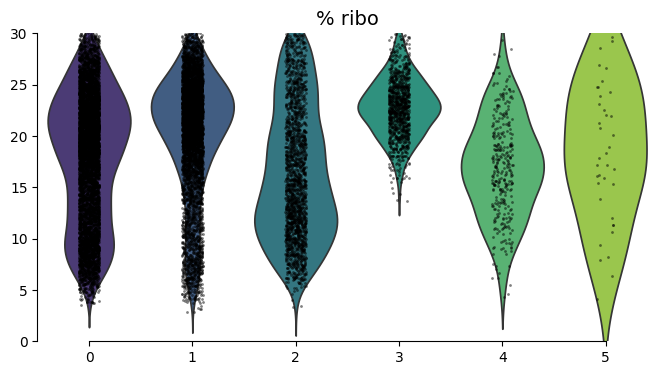

In [ ]:

plt.figure(figsize=(8,4))

sns.violinplot(
    x='leiden',
    y='pct_counts_ribo',
    data=df,
    palette='viridis',
    inner=None  
)


sns.stripplot(
    x='leiden',
    y='pct_counts_ribo',
    data=df,
    color='k',      
    size=2,         #Tamaño de los puntos
    alpha=0.5,      #Transparencia
    jitter=True     
)

plt.ylim(0,30)
plt.title("% ribo", fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.grid(False)
sns.despine(trim=True)
plt.show


C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_6768\3968677027.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


<function matplotlib.pyplot.show(close=None, block=None)>

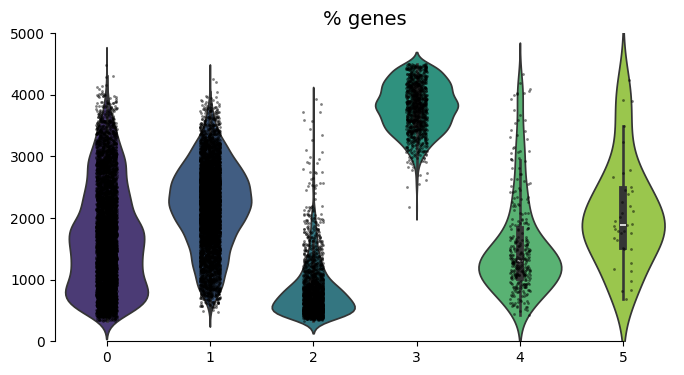

In [ ]:

plt.figure(figsize=(8,4))


sns.violinplot(
    x='leiden',
    y='n_genes',
    data=df,
    palette='viridis',
    inner="box"
)

sns.stripplot(
    x='leiden',
    y='n_genes',
    data=df,
    color='k',   
    size=2,        
    alpha=0.5,     
    jitter=True     
)

plt.ylim(0,5000)
plt.title("% genes", fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.grid(False)
sns.despine(trim=True)
plt.show

## Guardar objeto
A continuación se guarda el objeto AnnData que incluirá los conteos normalizados y una columna extra en la que indica a que clúster pertenece cada célula. Este objeto será importante para realizar análisis posteriores en los que se busque identificar diferencias de señalización (Cellphonedb) o de regulación metabólica (GSVA) entre los diferentes clústeres.


In [ ]:
file_path = "./pickles/counts_mouse_3_leiden_new.pkl" #Cambiar por la ruta y nombre que sea necesario

with open(file_path, "wb") as f:
    pickle.dump(counts, f)

# Análisis de la expresión diferencial.
En esta sección se identificarán los **genes diferencialmente expresados (DEGs)** del dataset mediante dos enfoques complementarios:

- **Expresión diferencial por clúster:** permite detectar los genes característicos o marcadores de cada grupo celular identificado en el análisis de clustering.  
- **Expresión diferencial por condición experimental:** compara la expresión génica entre las células pertenecientes a la condición **`plus_trp`** y las de otras condiciones.


Para llevar a cabo estos análisis se emplean las siguientes **funciones de Scanpy**:

- **`tl.rank_genes_groups`**: calcula los genes diferencialmente expresados entre grupos o condiciones, utilizando métodos estadísticos como *t-test*, *Wilcoxon rank-sum* o *logreg*.  
- **`get.rank_genes_groups_df`**: extrae los resultados del análisis anterior en formato de **DataFrame**, facilitando su inspección, filtrado y posterior análisis.



### Comparación de la expresión diferencial de cada clúster vs el resto

In [ ]:
sc.tl.rank_genes_groups(counts, 'leiden')

C:\Users\Sheimoon\AppData\Local\Temp\ipykernel_15072\2908502303.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(counts_leiden, resolution = 0.3, random_state=42)


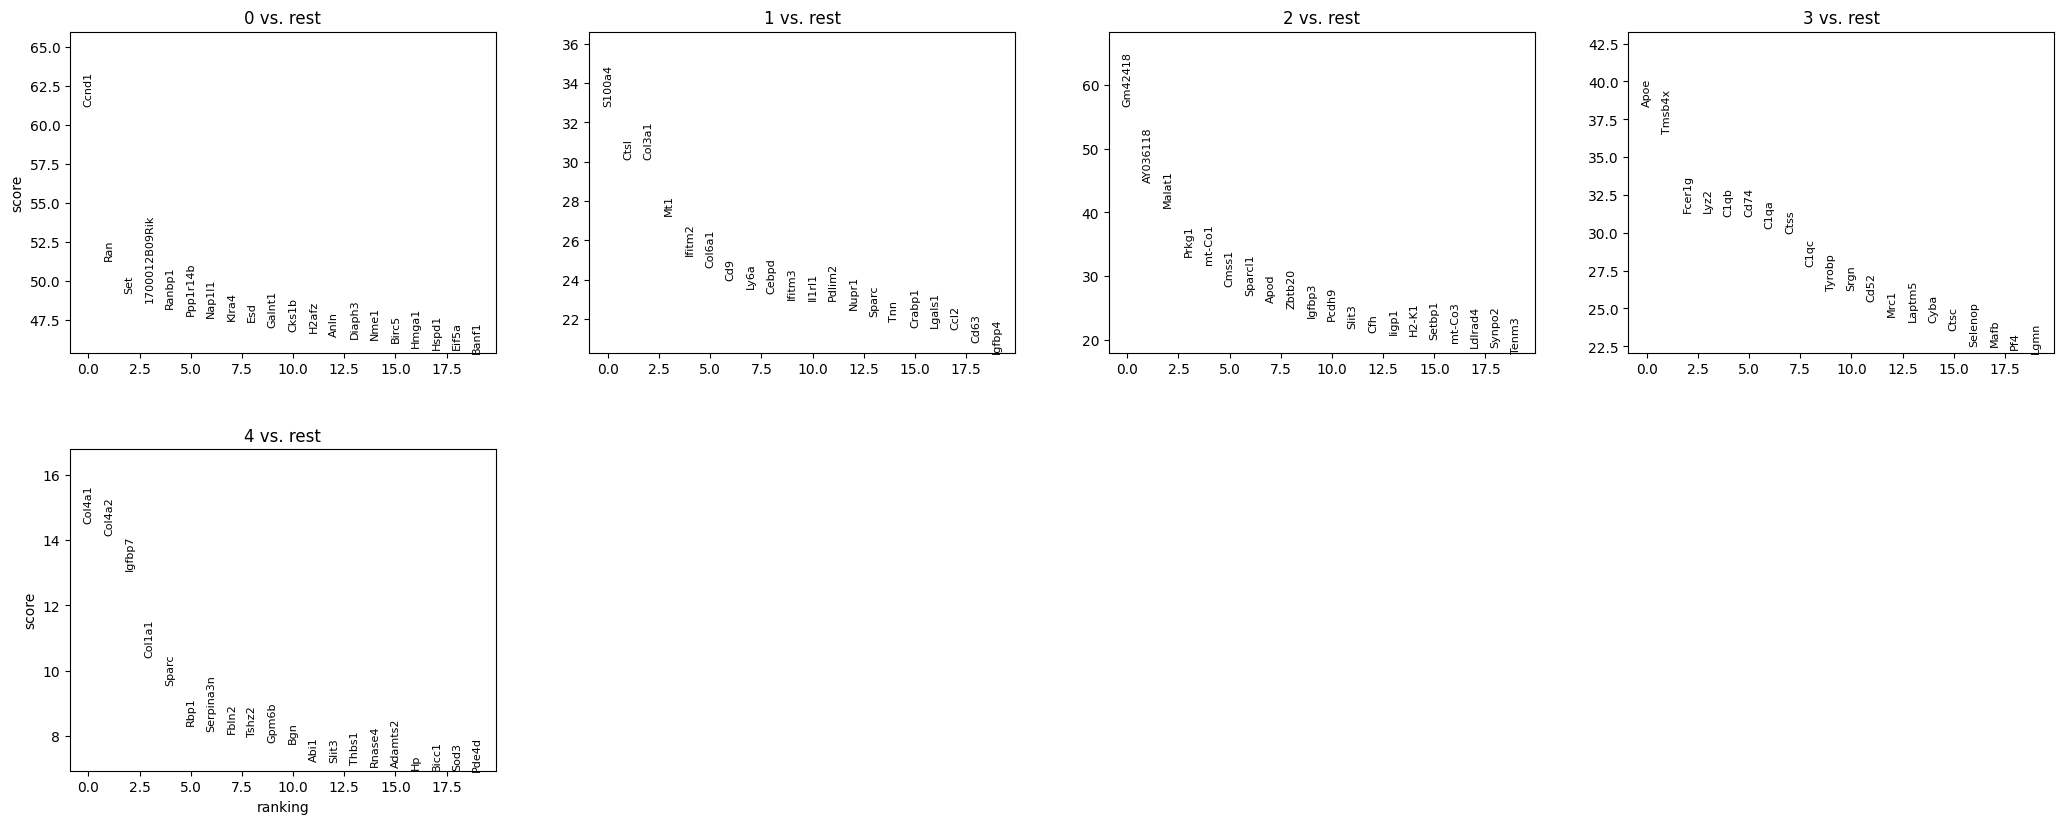

In [ ]:
sc.pl.rank_genes_groups(counts, n_genes=20, sharey=False)

markers_leiden = sc.get.rank_genes_groups_df(counts, None)


La grafica que se genera muestra los 20 genes cuya expresión se ha visto más alterada en cada clúster en comparación con el resto.

### Filtrado de genes diferencialmente expresados

Una vez obtenidos los resultados, los genes se **filtran según criterios de relevancia estadística y biológica**:

- **Genes infra expresados (down-regulated):** se conservan aquellos genes con un valor de p ajustado menor a 0.001 y un log fold change menor a **-1**.  
- **Genes sobre expresados (up-regulated):** se seleccionan los genes con un valor de p ajustado menor a **0.001** y un log fold change mayor a **1**.

Este filtrado asegura que solo se consideren genes con diferencias significativas y relevantes entre clústeres o condiciones. En el pool inicial se filtró por un valor de LogFc de |0,7| para capturar un rango más amplio de genes ya que la expresión diferencial no se veía tan afectada como en los ratones.  


### **Genes infra expresados**

In [ ]:
markers_leiden_down = markers_leiden[
    (markers_leiden.pvals_adj < 0.001) & 
    (markers_leiden.logfoldchanges < -1)
]

markers_leiden_down = markers_leiden_down.sort_values(by="pvals_adj", ascending=True)

markers_leiden_down

,group,names,scores,logfoldchanges,pvals,pvals_adj
96848,5,Lamc2,-44.542297,-27.203814,0.000000,0.000000
96849,5,Tma16,-46.193161,-27.110212,0.000000,0.000000
96846,5,Nceh1,-44.057770,-27.189857,0.000000,0.000000
96847,5,Neto2,-44.104126,-27.285093,0.000000,0.000000
96845,5,Ppp1r15b,-44.055378,-27.186991,0.000000,0.000000
...,...,...,...,...,...,...
63621,3,Mzb1,-3.507711,-2.713973,0.000455,0.000987
63622,3,Ppfia3,-3.509216,-1.587491,0.000457,0.000989
75635,4,Men1,-3.583545,-1.021979,0.000387,0.000992
75632,4,Mettl7b,-3.582012,-1.484414,0.000388,0.000993


#### **Genes sobre expresados**

In [ ]:
markers_leiden_up = markers_leiden[
    (markers_leiden.pvals_adj < 0.001) & 
    (markers_leiden.logfoldchanges > 1)
]
markers_leiden_up = markers_leiden_up.sort_values(by="pvals_adj", ascending=True)



,group,names,scores,logfoldchanges,pvals,pvals_adj
48428,3,Pfn1,61.166458,1.220689,0.000000,0.000000
48455,3,Ppp1r14b,49.250599,1.257743,0.000000,0.000000
48456,3,Anxa2,49.236435,1.100260,0.000000,0.000000
48427,3,Ybx1,68.298134,1.375697,0.000000,0.000000
48426,3,Rps2,69.013458,1.216559,0.000000,0.000000
...,...,...,...,...,...,...
32638,2,Scn7a,3.521348,2.835887,0.000438,0.000968
65785,4,C5ar2,3.589871,5.425057,0.000382,0.000980
80843,5,Sfrp1,3.958734,9.628645,0.000329,0.000983
65786,4,Ripk3,3.587531,6.561014,0.000385,0.000988


#### **Guardar los genes diferencialmente expresados de cada clúster**

In [ ]:
# Crear carpeta de salida si no existe
output_dir = "./Gen_Markers_Mouse_3/Leiden" #Cambiar el path por el que se considere
os.makedirs(output_dir, exist_ok=True)

Para relacionar los genes diferencialmente expresados con sus **IDs de Ensembl**, se ha generado un archivo de referencia a partir de **[Ensembl BioMart](https://www.ensembl.org/biomart/martview/)**.  

El procedimiento es el siguiente:

1. **Database:** seleccionar **Ensembl Genes 115**.  
2. **Dataset:** seleccionar **Mouse genes (Mus musculus)**.  
3. **Atributos:** elegir únicamente las opciones **Gene Stable ID** y **Gene Name**.  
4. **Exportar resultados:** en formato **CSV**, que contendrá el listado completo de genes con sus identificadores.

Este archivo servirá como **referencia en múltiples notebooks**, por lo que permanecerá **constante** a lo largo de todos los análisis posteriores.  
Tener este archivo estandarizado facilita la **integración de resultados de expresión diferencial** con bases de datos externas, anotaciones biológicas y herramientas de análisis funcional como **[DAVID](https://davidbioinformatics.nih.gov/home.jsp)**.

In [ ]:
genes = pd.read_csv("./Gen_markers/gen_id.csv", sep=",")

In [ ]:

clusters = counts.obs['leiden'].unique().tolist()

# Loop para cada cluster
for cluster in clusters:
    print(f"\n Procesando cluster {cluster}...")

    # Filtrar markers según el cluster actual
    markers_up = markers_leiden_up[markers_leiden_up['group'] == cluster]
    markers_down = markers_leiden_down[markers_leiden_down['group'] == cluster]

    merged_up = pd.merge(
        markers_up,
        genes,
        left_on="names",
        right_on="Gene name",
        how="left"
    ).drop(columns=["Gene name"])

    merged_down = pd.merge(
        markers_down,
        genes,
        left_on="names",
        right_on="Gene name",
        how="left"
    ).drop(columns=["Gene name"])

    # Guardar los resultados
    merged_up.to_csv(
        f"{output_dir}/markers_mouse_3_leiden_cluster_{cluster}_up.csv", #Cambiar nombre  según sea necesario
        sep="\t", index=False
    )
    merged_down.to_csv(
        f"{output_dir}/markers_mouse_3_plus_trp_cluster_{cluster}_down.csv", #Cambiar nombre  según sea necesario
        sep="\t", index=False
    )

    print(f" Guardados: cluster_{cluster}_up.csv y cluster_{cluster}_down.csv")




## Comparación de la expresión diferencial de la condición plus tritófano (plus_trp) vs el resto


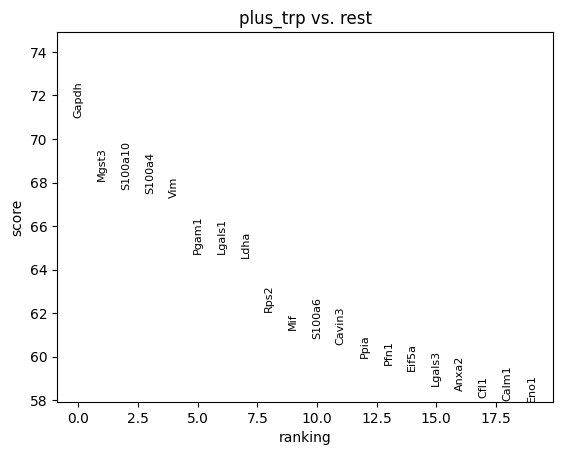

In [ ]:
sc.tl.rank_genes_groups(
    counts,
    groupby="condition",     
    groups=["plus_trp"],     
    reference="rest"         
)
markers_condition = sc.get.rank_genes_groups_df(counts, None)

sc.pl.rank_genes_groups(counts, n_genes=20, sharey=False)


#### **Genes inframexpresados**

In [ ]:
markers_condition_down = markers_condition[
    (markers_condition.pvals_adj < 0.001) & (markers_condition.logfoldchanges < -1)
]

# Ordenar por p-valor ajustado
markers_condition_down = markers_condition_down.sort_values(by="pvals_adj", ascending=True)

markers_condition_down

,names,scores,logfoldchanges,pvals,pvals_adj
16139,AY036118,-51.160866,-1.355597,0.000000e+00,0.000000e+00
16138,Malat1,-49.770660,-1.188398,0.000000e+00,0.000000e+00
16137,Gm42418,-47.932423,-1.077920,0.000000e+00,0.000000e+00
16134,Slit3,-33.573467,-1.562179,2.479506e-234,8.663242e-233
16133,Pde4d,-28.789804,-1.475096,3.571820e-175,8.541677e-174
...,...,...,...,...,...
14282,Col24a1,-3.514435,-2.250834,4.432566e-04,9.412061e-04
14281,Nrg4,-3.514195,-2.003160,4.434694e-04,9.415341e-04
14280,Apba1,-3.512832,-1.833005,4.456699e-04,9.458326e-04
14273,Pcsk5,-3.506056,-2.862692,4.574673e-04,9.692134e-04


### **Genes sobre expresados**



In [ ]:
markers_condition_up = markers_condition[
    (markers_condition.pvals_adj < 0.001) & (markers_condition.logfoldchanges > 1)
]

# Ordenar por p-valor ajustado
markers_condition_up = markers_condition_up.sort_values(by="pvals_adj", ascending=True)


markers_condition_up

,names,scores,logfoldchanges,pvals,pvals_adj
19,Eno1,57.932861,1.832457,0.000000,0.000000
80,Serpinb6a,49.832375,1.566060,0.000000,0.000000
79,Rpl17,49.900005,1.251292,0.000000,0.000000
78,Rps11,49.901131,1.228271,0.000000,0.000000
77,Rpl41,49.911903,1.132567,0.000000,0.000000
...,...,...,...,...,...
5625,Nphs1,3.700916,1.064250,0.000216,0.000472
5636,Plet1os,3.692799,1.223437,0.000223,0.000486
5657,Gm8883,3.652642,1.618462,0.000260,0.000565
5716,Gm4129,3.556322,2.147872,0.000377,0.000806


### *Análisis Funcional*
En esta sección se realiza un **análisis de enriquecimiento funcional** sobre los genes **diferencialemnte expresados** utilizando la herramienta *Enrichr* a través de `gseapy`. Primero, se extrae la lista de genes de interés y se define un conjunto de bases de datos funcionales (GO, KEGG, Reactome y Hallmark). Luego, se ejecuta el análisis de enriquecimiento de forma iterativa para cada *gene set*, recopilando y concatenando los términos funcionales obtenidos en un único dataframe. Finalmente, los resultados se ordenan según el *Adjusted P-value*, se exportan a un archivo CSV y se muestran para su posterior interpretación. 


#### Genes Infra expresados



In [ ]:
# Crear dataframe vacío para resultados
all_enrich_results_down = pd.DataFrame()

# Lista de genes down-regulados
genes_down = markers_condition_down['names'].tolist()

# Lista de gene sets a consultar
gene_sets_list = [
    'GO_Biological_Process_2025',
    'KEGG_2019_Mouse',
    'Reactome_Pathways_2024',
    'MSigDB_Hallmark_2020'
]

# Bucle sobre cada gene set
for gene_set in gene_sets_list:
    enr = gp.enrichr(
        gene_list=genes_down,
        gene_sets=[gene_set],
        organism='Mouse',
        outdir='enrichr_down_results',
        cutoff=1.00
    )
    
    # Filtrar términos significativos
    significant_terms = enr.results
    
    # Concatenar al dataframe total
    all_enrich_results_down = pd.concat([all_enrich_results_down, significant_terms], ignore_index=True)

# Ordenar por Adjusted P-value
all_enrich_results_down = all_enrich_results_down.sort_values(by='Adjusted P-value')


In [ ]:
all_enrich_results_down = all_enrich_results_down.reset_index(drop=True)

# Exportar a CSV
all_enrich_results_down.to_csv("./Gen_Markers_Mouse_3/Condition/enrichr_down_trpvsrest_results.csv", sep = "\t", index=False)

all_enrich_results_down

#### Genes Sobre expresados

In [ ]:
# Crear dataframe vacío para resultados
all_enrich_results_up = pd.DataFrame()

# Lista de genes up-regulados
genes_up = markers_condition_up['names'].tolist()

# Lista de gene sets a consultar
gene_sets_list = [
    'GO_Biological_Process_2025',
    'KEGG_2019_Mouse',
    'Reactome_Pathways_2024',
    'MSigDB_Hallmark_2020'
]

# Ejecutar Enrichr en bucle
for gene_set in gene_sets_list:
    enr = gp.enrichr(
        gene_list=genes_up,
        gene_sets=[gene_set],
        organism='Mouse',
        outdir='enrichr_up_results',
        cutoff=1.0
    )

    # Filtrar términos significativos
    significant_terms = enr.results
    
    # Concatenar al dataframe total
    all_enrich_results_up = pd.concat([all_enrich_results_up, significant_terms], ignore_index=True)

# Ordenar por Adjusted P-value
all_enrich_results_up = all_enrich_results_up.sort_values(by='Adjusted P-value')

In [ ]:
all_enrich_results_up = all_enrich_results_up.reset_index(drop=True)

# Exportar a CSV
all_enrich_results_up.to_csv("./Gen_Markers_Mouse_3/Condition/enrichr_up_trpvsrest_results.csv", sep = "\t", index=False)

all_enrich_results_up

### **Guardar los genes diferencialmente expresados**



In [ ]:
# Crear carpeta de salida si no existe
output_dir = "./Gen_Markers_Mouse_3/Condition" #Cambiar el path por el que se considere
os.makedirs(output_dir, exist_ok=True)

In [ ]:
merged_up = pd.merge(
    markers_condition_up,
    genes,
    left_on="names",
    right_on="Gene name",
    how="left"
    ).drop(columns=["Gene name"])

merged_down = pd.merge(
    markers_condition_down,
    genes,
    left_on="names",
    right_on="Gene name",
    how="left"
    ).drop(columns=["Gene name"])

    # Guardar los resultados
merged_up.to_csv(
    f"{output_dir}/markers_mouse_3_plus_trp_up.csv", #Cambiar nombre  según sea necesario
        sep="\t", index=False
    )
merged_down.to_csv(
        f"{output_dir}/markers_mouse_3_plus_trp_down.csv", #Cambiar nombre  según sea necesario
        sep="\t", index=False
    )

### Heatmap

Finalmente, en esta sección se generan **heatmaps** que muestran los genes con mayor expresión diferencial en la condición plus_trp, comparándolo para cada condición experimental. Para ello, se emplea la función **`sc.pl.rank_genes_groups_heatmap`** de Scanpy estandarizando la expresión por gen (`standard_scale="var"`) y usando un mapa de colores **RdBu_r** para facilitar la comparación visual.

Primero se crea un heatmap contando todas las células de cada condición, pero como la mayoría de condiciones tienen pocas células en comparación con las células de la condición plus_trp; por lo que el heatmap, queda visualmente desvalanceado y no sepueden ver la mayoría de condiciónes. Por ello, se realiza un **submuestreo por grupo**, seleccionando un número equilibrado de células de cada condición. Con estas células balanceadas se genera un segundo heatmap, permitiendo comparar los patrones de expresión entre todas las condiciones.


c:\Python311\Lib\site-packages\anndata\_core\anndata.py:1175: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


categories: control_1, control_2, no_his, etc.
var_group_labels: plus_trp


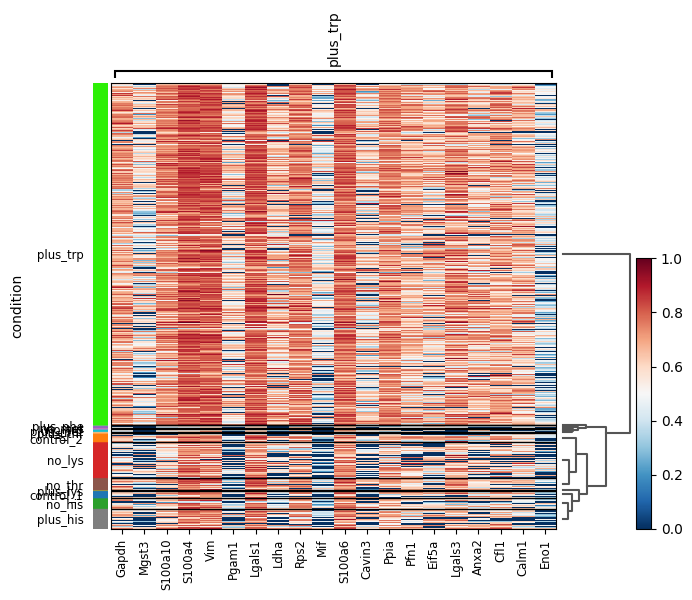

In [ ]:
adata_clean = counts.copy()
adata_clean.obs['condition'] = adata_clean.obs['condition'].astype(str)
adata_clean = adata_clean[adata_clean.obs['condition'] != 'nan']


sc.pl.rank_genes_groups_heatmap(
    adata_clean,
    n_genes=20,
    groupby="condition",
    use_raw=True,
    standard_scale="var",
    cmap="RdBu_r"
)

#### Heatmap con submuestremo

categories: control_1, control_2, no_his, etc.
var_group_labels: plus_trp


c:\Python311\Lib\site-packages\scanpy\plotting\_utils.py:482: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


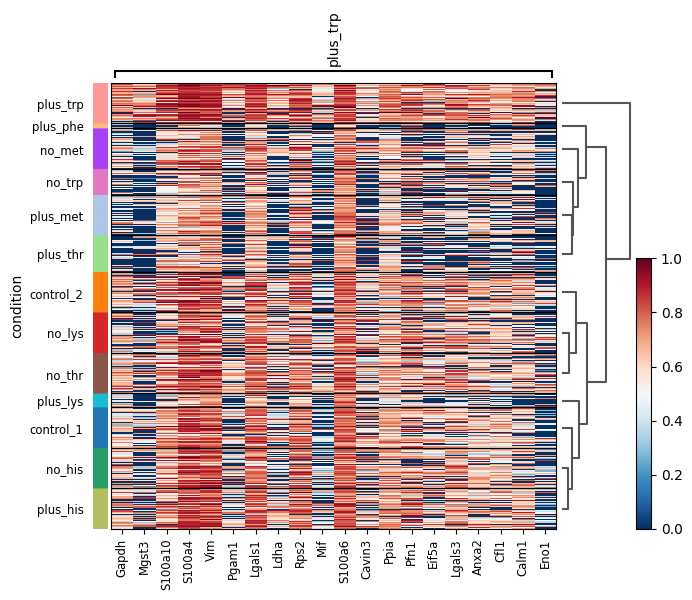

In [ ]:
n_cells = 50

# Submuestreo por grupo
groups = adata_clean.obs['condition'].unique()
indices = []

for group in groups:
    group_indices = adata_clean.obs_names[adata_clean.obs['condition'] == group]
    sampled = np.random.choice(group_indices, size=min(n_cells, len(group_indices)), replace=False)
    indices.extend(sampled)


adata_balanced = adata_clean[indices]

sc.pl.rank_genes_groups_heatmap(
    adata_balanced,
    n_genes=20,
    groupby="condition",
    use_raw=True,
    standard_scale="var",
    cmap="RdBu_r"
)
